In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi, argmax, exp, sqrt, complex128, array
import time

In [2]:
import seaborn as sns
sns.set_theme()

In [3]:
Fs = 1e6
F0 = 1e5
T = 1 / Fs
w0 = 2* pi * F0
phi= pi/8
A = 1
N = 513

k = [10,12,14,16,18,20]
fft_sizes = [2**k for k in k]
SNRs = [-10, 0, 10, 20, 30, 40, 50, 60]
n = np.arange(-256, 257)
x = A * exp(1.j*(w0*n*T+phi))

#### Closest Frequency bin

In [4]:
# error to closest frequency bin
for bin in Fs/ array(fft_sizes):
    closest_bin = np.min(np.abs(np.arange(0, Fs/2, bin) - F0))
    print('{:0.2e} '.format(closest_bin**2))


1.53e+05 
9.54e+03 
5.96e+02 
3.73e+01 
2.33e+00 
1.46e-01 


In [5]:
[ '{:.2f}'.format(fft_size) for fft_size in  Fs/ array(fft_sizes) ]

['976.56', '244.14', '61.04', '15.26', '3.81', '0.95']

# CRLB

In [6]:
SNR_linear = 10.0**(array(SNRs)/10)
Sigma_2 = (A**2)/(2*SNR_linear)
P = (N*(N-1)) / 2
Q = (N*(N-1)*(2*N-1)) / 6

In [7]:
CRLB_f = 12* Sigma_2 / (A**2 * T**2 *N*(N**2-1) )  / 4 / pi**2
CRLB_phi = 12* Sigma_2 * ((n[0]**2)*N + 2*n[0]*P + Q) / (A**2 * N**2 * (N**2 - 1))

In [8]:
CRLB_f,CRLB_phi

(array([1.1257477e+04, 1.1257477e+03, 1.1257477e+02, 1.1257477e+01,
        1.1257477e+00, 1.1257477e-01, 1.1257477e-02, 1.1257477e-03]),
 array([9.74658869e-03, 9.74658869e-04, 9.74658869e-05, 9.74658869e-06,
        9.74658869e-07, 9.74658869e-08, 9.74658869e-09, 9.74658869e-10]))

Create signal

Add noise

$$
SNR = \frac {P_\text{signal}}{P_\text{noise}} \\ \Downarrow \\
\sigma^2 = P_\text{noise}= \frac {P_\text{signal}}{SNR } \\
\\~\\
P = \frac 1 N \sum_{n=0}^{N-1}|x[n]|^2 =    \frac 1 N \bm x^H\cdot \bm x
$$
Or just use the formula when we know A

$$
SNR = \frac {A^2} {2\sigma^2} \\
\Downarrow \\
\sigma = \sqrt{\frac{A^2}{2\cdot SNR}}

$$


In [9]:
def addNoise(snr_db, x): 
    # signal_average_power = (x @ x.conj().T).real / len(x) 
    signal_average_power = A**2 

    # shared equally by the real and imaginary part of the noise 
    noise_average_power = signal_average_power / 10**(snr_db/10) / 2 

    # normal(mean, variance, dimensions)
    noise = np.random.normal(0, sqrt(noise_average_power), (len(x),2)).view(complex128)[:,0]

    return x+ noise 

In [10]:
def F(signal, frq):
    #data = x * np.exp(-1j *2 * np.pi * frq * n *T)
    #return np.sum(data) / N

    # Using matrix operations yields the same result and is faster.
    return signal @ exp(-1j *2 * pi * frq * n *T).T /N
    

# 1 A

In [11]:
mean = 10000

frq_error = np.empty((len(fft_sizes), len(SNRs), mean))
phase_error = np.empty((len(fft_sizes), len(SNRs), mean))

timeings =  []

for i, fft_size in enumerate(fft_sizes):

    start = time.time()
    frqs = np.fft.fftfreq(fft_size, T)
    # Run simulation several times for better statistics.
    for j in range(mean):
        # Doing all SNRs in one go
        signal = [addNoise(SNR, x) for SNR in SNRs] 

        # np.fft.fft zeropads autmatically when fft_size is bigger than signal length
        fft = np.fft.fft(signal,fft_size)
        pxx = np.abs(fft)**2 #/ fft_size / N

        peak_idx = argmax(pxx,1)
        peak_frq = frqs[peak_idx]
        #peak_phase = array([np.angle(fft[i, c]) for i, c in enumerate(peak_idx)])

        # We are interested in the phase at sample n[N//2] = 0. We do not need to rotate the fase to n[0] = -256
        # that is why we can disregard mutliplication with the exp shown in eq. 7, and take the angle of F directly. 

        #phase_est = array([np.angle(exp(-1.j*2*pi*frq_est*n[0]*T)*F(x,frq_est)) for x, frq_est in zip(signal, peak_frq)])
        phase_est = array([np.angle(F(x,frq_est)) for x, frq_est in zip(signal, peak_frq)])
        
        # These are vector operations, done for all SNRs at current fft_size.
        frq_error[i,:,j] = F0 - peak_frq 
        phase_error[i,:,j] = phi - phase_est
    timeings.append(time.time() - start)

In [12]:
np.save('frq_error_10k.npy', frq_error)
np.save('phase_error_10k.npy', phase_error)
#frq_error = np.load('frq_error_10k.npy')
#phase_error = np.load('phase_error_10k.npy')

In [13]:
# Take the mean of frequency and phase estimates, for all fft_sizes and SNRs. 
frq_plot = np.mean(array(frq_error)**2,2)
phase_plot = np.mean(array(phase_error)**2,2)

Calculate frequency and phase estimates

In [14]:
#plt.plot(SNRs, frq_plot.T)
#plt.legend([f'$2^{{{k}}}$' for k in k ], title='FFT Size')
#plt.title('Frequency estimation error vs. SNR')
#plt.xlabel('SNR [dB]')
#plt.yscale("log")
#plt.ylabel('Mean Square Frequency Error [Hz]')


In [15]:
#plt.plot(SNRs, phase_plot.T)
#plt.legend([f'$2^{{{k}}}$' for k in k ], title='FFT Size')
#plt.title('Phase estimation error vs. SNR')
#plt.xlabel('SNR [dB]')
#plt.yscale("log")
#plt.ylabel('Mean Square Phase Error [rad]')

# 1B

In [16]:
from scipy.optimize import minimize
#mean = 10000

In [17]:
frq_error_f_max = np.empty((len(SNRs), mean))
phase_error_f_max = np.empty((len(SNRs), mean))

frqs = np.fft.fftfreq(2**10, T)

start = time.time()

for j in range(mean):
    # Doing all SNRs in one go
    signals = [addNoise(SNR, x) for SNR in SNRs] 
    fft = np.fft.fft(signals,2**10) 
    pxx = np.abs(fft)**2 #/ fft_size / N
    peak_idxs = argmax(pxx,1)
    peak_frq = frqs[peak_idxs]
    frq_est = []

    for i, SNR in enumerate(SNRs):
        signal = signals[i]
        peak_idx = peak_idxs[i]

        frq_est.append( 
            minimize(
                lambda frq: -np.abs(F(signal, frq)), 
                frqs[peak_idx], 
                method='Nelder-Mead',
                # The true peak could between the previous bin and the next
                bounds=[(frqs[peak_idx-1],frqs[peak_idx+1])]
            ).x[0]
        )
    
    frq_error_f_max[:,j] = F0 - array(frq_est)

    phase_est = [np.angle(F(x,frq_est)) for x, frq_est in zip(signals, frq_est)]
    #phase_est = [F(x,frq_est) for x, frq_est in zip(signals, frq_est)]
    phase_error_f_max[:,j] = phi - array(phase_est)

timeings.append(time.time() - start)

In [18]:
np.save('frq_error_fmax_10k.npy', frq_error_f_max)
np.save('phase_error_fmax_10k.npy', phase_error_f_max)
#frq_error_f_max = np.load('frq_error_fmax.npy')
#phase_error_f_max = np.load('phase_error_fmax.npy')

In [19]:
frq_plot_max = np.mean(frq_error_f_max**2,1)
phase_plot_max = np.mean(phase_error_f_max**2,1)

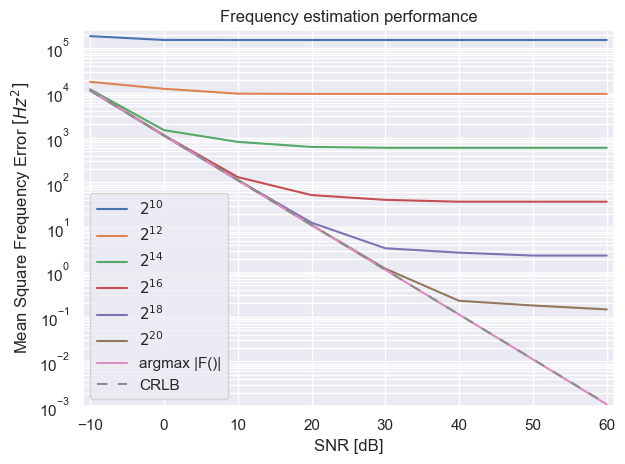

In [67]:
# Add column to the previous plot
#frq_plot_all =  np.c_[frq_plot.T,frq_plot_max]

label_all = [f'$2^{{{k}}}$' for k in k ]
label_all.append('argmax |F()|')
label_all.append('CRLB')

plt.plot(SNRs, frq_plot_all)
plt.plot(SNRs, CRLB_f, linestyle=(0, (5,5)))
plt.legend(label_all)
plt.title('Frequency estimation performance')
plt.xlabel('SNR [dB]')
plt.yscale("log")
plt.ylabel('Mean Square Frequency Error $[Hz^2]$')
plt.tight_layout()
plt.ylim((1e-3, 2.5e5))
plt.xlim((-11, 61))
plt.grid(True, which="both")
plt.savefig('frq_vs_snr.svg',format='svg')

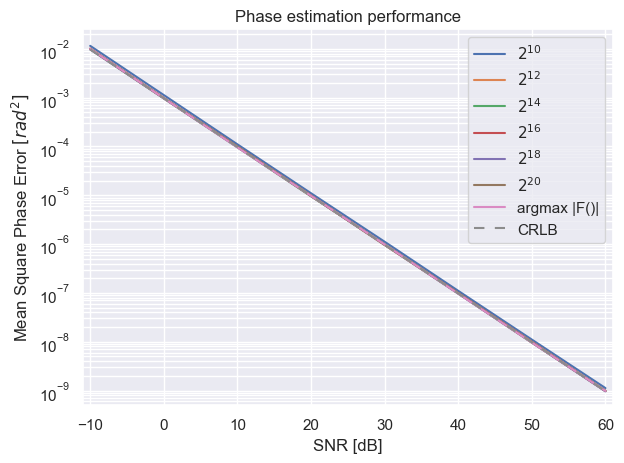

In [68]:
phase_plot_all =  np.c_[phase_plot.T,phase_plot_max.T]
plt.plot(SNRs, phase_plot_all)
plt.plot(SNRs, CRLB_phi, linestyle=(0, (5,5)))
plt.legend(label_all)
plt.title('Phase estimation performance')
plt.xlabel('SNR [dB]')
plt.yscale("log")
plt.ylabel('Mean Square Phase Error $[rad^2]$')
plt.tight_layout()
plt.ylim((5e-10, 2.5e-2))
plt.xlim((-11, 61))
plt.grid(True, which="both")
plt.tight_layout()
plt.savefig('phase_vs_snr.svg',format='svg')

In [69]:
frq_offsets = sqrt(frq_plot_all)-sqrt(CRLB_f[:,None].repeat(7, axis=1))
#plt.plot(SNRs,frq_offsets)
#plt.legend(label_all)
#plt.title('Frequency Error - CRLB')
#plt.xlabel('SNR [dB]')
#plt.ylabel('RMS Frequency [Hz]')
#plt.yscale('log')

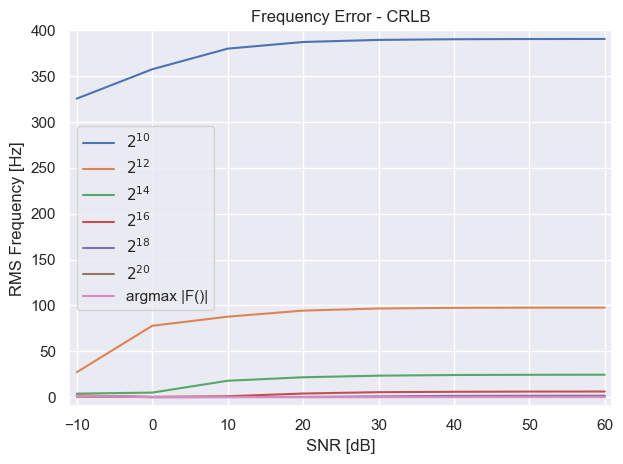

In [70]:
plt.plot(SNRs,frq_offsets)
plt.legend(label_all)
plt.title('Frequency Error - CRLB')
plt.xlabel('SNR [dB]')
plt.ylabel('RMS Frequency [Hz]')
plt.xlim((-11, 61))
plt.ylim((-10, 400))
plt.tight_layout()
plt.savefig('frq-crlb.svg',format='svg')


In [71]:
phase_offsets = sqrt(phase_plot_all)-sqrt(CRLB_phi[:,None].repeat(7, axis=1))
#plt.plot(SNRs,phase_offsets)
#plt.legend(label_all)
#plt.title('Phase Error - CRLB')
#plt.xlabel('SNR [dB]')
#plt.ylabel('RMS Phase Offset [rad]')
#plt.yscale('log')


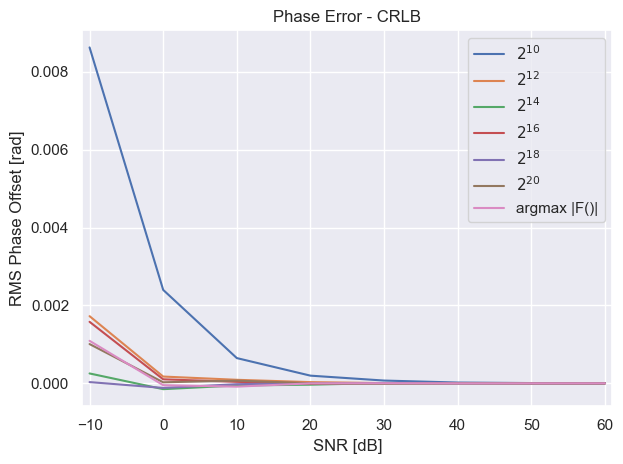

In [72]:
plt.plot(SNRs,phase_offsets)
plt.legend(label_all)
plt.title('Phase Error - CRLB')
plt.xlabel('SNR [dB]')
plt.ylabel('RMS Phase Offset [rad]')
plt.xlim((-11, 61))
#plt.ylim((-10, 400))
plt.tight_layout()
plt.savefig('phase-crlb.svg',format='svg')

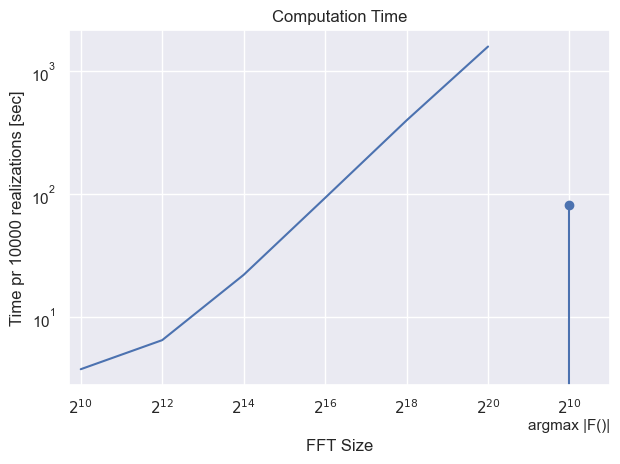

In [73]:
plt.plot(timeings[:-1])
plt.title('Computation Time')
plt.xlabel('FFT Size')
xlabel = [f'$2^{{{k}}}$' for k in k ]
xlabel.append('$2^{10}$\nargmax |F()|')
plt.xticks(range(len(xlabel)), xlabel)
plt.ylabel(f'Time pr {mean} realizations [sec]')
plt.yscale('log')
plt.stem(6, timeings[-1])

plt.xlim((-0.15, 6.5))
#plt.ylim((-10, 400))
plt.tight_layout()
plt.savefig('time_fft.svg',format='svg')
plt.show()

## Conclutions
* Frequency estimation error goes down with increased fft_size
    * Computational cost increases with fft_size
    * A rough frequency estimate from a lower fft_size can be used to increase acurracy, more than a longer fft_size
* Phase estimates is only depending on noise, not fft_size